In [1]:
import os
import string, warnings
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop = stopwords.words('english')
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from textblob import Word
from sklearn import model_selection, preprocessing, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikunjlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nikunjlad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("amazon_scrape.csv")

In [4]:
df.head(5)

,Name,Ratings,Review
0,E. Hinrichsen II,3.0 out of 5 stars,If you own an earlier Paperwhite and it's stil...
1,Sir Mike,4.0 out of 5 stars,"Updated Review on Oct 6, 2019:\n\nAfter nearly..."
2,Ship210,3.0 out of 5 stars,"I love Kindle, have always had one since the f..."
3,Rustic,5.0 out of 5 stars,I feel I need to approach this review from 2 p...
4,D. Bier,1.0 out of 5 stars,It’s infuriating that Amazon went to market wi...


In [5]:
def only_ratings(rate_str):
    return int(rate_str[:1])

def remove_newline(review_str):
    texts = []
    for i, line in enumerate(review_str.split("\n\n")):
        content = line.split()
        texts.append(" ".join(content[:]))

    review_str = " ".join(texts[:])
    
    return review_str

In [6]:
df["Ratings"] = df["Ratings"].apply(only_ratings)
df["Review"] = df["Review"].apply(remove_newline)

In [7]:
df.head()

,Name,Ratings,Review
0,E. Hinrichsen II,3,If you own an earlier Paperwhite and it's stil...
1,Sir Mike,4,"Updated Review on Oct 6, 2019: After nearly a ..."
2,Ship210,3,"I love Kindle, have always had one since the f..."
3,Rustic,5,I feel I need to approach this review from 2 p...
4,D. Bier,1,It’s infuriating that Amazon went to market wi...


In [8]:
X = list(df["Review"])
len(X)

4670

In [9]:
y = list(df["Ratings"])
len(y)

4670

In [10]:
len(stop)

179

In [11]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.05, random_state=333)
# x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train, test_size=0.1, random_state=333)

In [12]:
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.fit_transform(y_valid)

### Count Vectorizer

In [25]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train)
xvalid_count =  count_vect.transform(x_valid)

### TF-IDF (Term Frequency-Inverse Document Frequency)

In [14]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X)
xtrain_tfidf =  tfidf_vect.transform(x_train)
xvalid_tfidf =  tfidf_vect.transform(x_valid)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(X)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(x_valid)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_valid) 

In [15]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_valid), classifier

In [26]:
# Naive Bayes on Count Vectors
accuracy, cv_nb = train_model(MultinomialNB(), xtrain_count, y_train, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy, wtfidf_nb = train_model(MultinomialNB(), xtrain_tfidf, y_train, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy, ng_nb = train_model(MultinomialNB(), xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy, ctfidf_nb = train_model(MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.5299145299145299
NB, WordLevel TF-IDF:  0.47863247863247865
NB, N-Gram Vectors:  0.5641025641025641
NB, CharLevel Vectors:  0.4829059829059829


### Custom method for prediction

In [27]:
vocab = {}
for i in tqdm(range(len(x_train))):
    word_list = []
    for word in x_train[i].split():
        word_new  = word.strip(string.punctuation).lower()
        
        if (len(word_new)>2)  and (word_new not in stop):  
            if word_new in vocab:
                vocab[word_new]+=1
            else:
                vocab[word_new]=1

100%|██████████| 4436/4436 [00:01<00:00, 3872.82it/s]


In [28]:
max(vocab.values())

7691

In [29]:
len(vocab)

13144

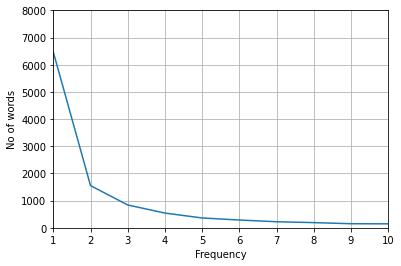

In [30]:
num_words = [0 for i in range(max(vocab.values())+1)] 
freq = [i for i in range(max(vocab.values())+1)] 
for key in vocab:
    num_words[vocab[key]]+=1
plt.plot(freq,num_words)
plt.axis([1, 10, 0, 8000])
plt.xlabel("Frequency")
plt.ylabel("No of words")
plt.grid()
plt.show()


In [31]:
cutoff_freq = 15
# For deciding cutoff frequency
num_words_above_cutoff = len(vocab)-sum(num_words[0:cutoff_freq]) 
print("Number of words with frequency higher than cutoff frequency({}) :".format(cutoff_freq),num_words_above_cutoff)

Number of words with frequency higher than cutoff frequency(15) : 1931


In [32]:
# Words with frequency higher than cutoff frequency are chosen as features
# (i.e we remove words with low frequencies as they would not be significant )
features = []
for key in vocab:
    if vocab[key] >=cutoff_freq:
        features.append(key)

In [33]:
# To represent training data as word vector counts
X_train_dataset = np.zeros((len(x_train),len(features)))
# This can take some time to complete
for i in tqdm(range(len(x_train))):
    # print(i) # Uncomment to see progress
    word_list = [ word.strip(string.punctuation).lower() for word in x_train[i].split()]
    for word in word_list:
        if word in features:
            X_train_dataset[i][features.index(word)] += 1

100%|██████████| 4436/4436 [00:10<00:00, 428.39it/s]


In [34]:
X_test_dataset = np.zeros((len(x_valid),len(features)))
# This can take some time to complete
for i in tqdm(range(len(x_valid))):
    # print(i) # Uncomment to see progress
    word_list = [ word.strip(string.punctuation).lower() for word in x_valid[i].split()]
    for word in word_list:
        if word in features:
            X_test_dataset[i][features.index(word)] += 1

100%|██████████| 234/234 [00:00<00:00, 451.37it/s]


In [35]:
# Using sklearn's Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(X_train_dataset,y_train)
Y_test_pred = clf.predict(X_test_dataset)
sklearn_score_train = clf.score(X_train_dataset,y_train)
print("Score on training data :",sklearn_score_train)
sklearn_score_test = clf.score(X_test_dataset,y_valid)
print("Score on testing data :",sklearn_score_test)

Score on training data : 0.7227231740306582
Score on testing data : 0.5769230769230769


### Predicting on some review

In [40]:
review_text = np.array(["Don't buy into the petty negative reviews. The improvements to the basic Kindle are great! \
I've been reading on mine the past several days and I'm extremely impressed. The lighting is the brightest,\
whitest and most even I've seen. It's comfortable to hold, easy to read, and just as responsive as my Oasis \
and my husband's Paperwhite. Highly recommend!"])

In [41]:
review_text.shape

(1,)

In [42]:
review_text.reshape(-1,1)

array([["Don't buy into the petty negative reviews. The improvements to the basic Kindle are great! I've been reading on mine the past several days and I'm extremely impressed. The lighting is the brightest,whitest and most even I've seen. It's comfortable to hold, easy to read, and just as responsive as my Oasis and my husband's Paperwhite. Highly recommend!"]],
      dtype='<U352')

In [63]:
text = count_vect.transform(review_text)

In [64]:
output = cv_nb.predict(text)
probs = cv_nb.predict_proba(text)
print(probs)
print("Review rating: {}".format(str(output[0])))

[[2.66009116e-12 4.52748018e-11 4.59269972e-08 2.65885704e-05
  9.99973365e-01]]
Review rating: 4


In [45]:
text = tfidf_vect.transform(review_text)

In [48]:
output = wtfidf_nb.predict(text)
probs = wtfidf_nb.predict_proba(text)
print(probs)
print("Review rating: {}".format(str(output[0] + 1)))

[[0.00513408 0.00324104 0.01776108 0.05141378 0.92245001]]
Review rating: 5


In [50]:
text = tfidf_vect_ngram.transform(review_text)

In [54]:
output = ng_nb.predict(text)
probs = ng_nb.predict_proba(text)
print(probs)
print("Review rating: {}".format(str(output[0] + 1)))

[[0.02123624 0.02008869 0.05912344 0.11215182 0.78739981]]
Review rating: 5


In [55]:
text = tfidf_vect_ngram_chars.transform(review_text)

In [56]:
output = ctfidf_nb.predict(text)
probs = ctfidf_nb.predict_proba(text)
print(probs)
print("Review rating: {}".format(str(output[0] + 1)))

[[0.00377119 0.00356624 0.01602822 0.0505115  0.92612285]]
Review rating: 5


In [59]:
sample = np.zeros((1,len(features)))
# This can take some time to complete
word_list = [ word.strip(string.punctuation).lower() for word in review_text[0].split()]
for word in word_list:
    if word in features:
        sample[0][features.index(word)] += 1

In [60]:
sample.shape

(1, 1931)

In [61]:
output = clf.predict(sample)
probs = clf.predict_proba(sample)
print(probs)
print("Review rating: {}".format(str(output[0] + 1)))

[[2.19940448e-08 4.14239613e-08 2.53466137e-06 3.94644099e-04
  9.99602758e-01]]
Review rating: 5
